# Inverse design of a GaP photon extractor for nitrogen-vacancy centers in diamond 

Designing a light extractor is crucial for enhancing photon collection efficiency in solid-state defect qubit systems, which are valuable for quantum information and metrology applications. In high refractive index materials like diamond, total internal reflection limits the ability to collect photons emitted from qubits. By optimizing light extraction through nanophotonic structures, such as waveguides or planar dielectric structures, one can significantly increase the emission directed toward detectors, improving photoluminescence detection. 

In this notebook, we use inverse design to optimize a GaP extractor structure following a similar approach discussed in `Srivatsa Chakravarthi, Pengning Chao, Christian Pederson, Sean Molesky, Andrew Ivanov, Karine Hestroffer, Fariba Hatami, Alejandro W. Rodriguez, and Kai-Mei C. Fu, "Inverse-designed photon extractors for optically addressable defect qubits," Optica 7, 1805-1811 (2020)` [DOI: 10.1364/OPTICA.408611](https://doi.org/10.1364/OPTICA.408611). The optimization aims to maximize the minimum upward flux among three simulations with the dipole source oriented in the $x$, $y$, and $z$ directions. The final design achieves an order-of-magnitude enhancement in upward flux for an in-plane dipole source and over two orders of magnitude for an out-of-plane dipole source compared to the configuration without an extractor.

<img src="img/adjoint_21.png" width=400 alt="Schematic of the light extractor">

If you are unfamiliar with inverse design, we also recommend our [intro to inverse design tutorials](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and our [primer on automatic differentiation with tidy3d](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/). For another example of light extractor optimization in Tidy3D, see [this example](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd12LightExtractor/).

In [1]:
import autograd.numpy as np
import autograd as ag
import optax
import matplotlib.pyplot as plt
import gdstk
import tidy3d as td
import tidy3d.web as web

## Static Simulation Components

In this case, we are focusing on the photonic coupling to the negatively charged sharp zero-phonon line (ZPL) of nitrogen-vacancy centers at 637 nm. 

In [2]:
lda0 = 0.637  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
fwidth = freq0 / 10  # width of the source frequency range

For the extractor structure on top of diamond, a high-index material is preferred. GaP with a refractive index of 3.31 is used in this design. 

In [3]:
# define materials
n_GaP = 3.31
GaP = td.Medium(permittivity=n_GaP**2)

n_diamond = 2.417
diamond = td.Medium(permittivity=n_diamond**2)

The GaP layer thickness is 250 nm. The design region is very compact, only 1.5 μm by 1.5 μm. The design region is discretized into 10 nm grids. To ensure the FDTD grid is commensurate with the pixel, we will use the automatic nonuniform grid with `min_steps_per_wvl = lda0 / (pixel_size * n_GaP)`.

The minimal feature size we are aiming for is 50 nm, compatible with electron beam lithography fabrication. 

In [4]:
h = 0.25  # thickness of the extractor layer
l = 1.5  # size of the design region
pixel_size = 0.01  # pixel size in the design region
min_steps_per_wvl = lda0 / (pixel_size * n_GaP)  # automatic grid size parameter

min_feature = 0.05  # minimal feature size

inf_eff = 1e3  # effective infinity
buffer = 0.5  # buffer spacing
run_time = 4e-13  # simulation run time

Now we define static components in the optimization. This includes the diamond substrate structure, the dipole sources, and the monitor that records the upward flux. The dipole source is located 100 nm below the top diamond surface.

In this case, we will place a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) to record the upward radiation flux instead of directly using a [FluxMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FluxMonitor.html) because differentiation with respect to flux monitor data is not supported at the moment. 

In [5]:
# define the diamond substrate
substrate = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)),
    medium=diamond,
)

# define the dipole sources oriented in the x, y, and z directions
dipole_z = -0.1  # dipole depth
pd_x = td.PointDipole(
    center=(0, 0, dipole_z),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    polarization="Ex",
)

pd_y = pd_x.updated_copy(polarization="Ey")
pd_z = pd_x.updated_copy(polarization="Ez")

# define the field monitor above the extractor to measure the upward flux
monitor_z = h + 0.4  # monitor height
monitor_size = 1.5  # monitor size

field_monitor = td.FieldMonitor(
    center=(0, 0, monitor_z),
    size=(monitor_size, monitor_size, 0),
    freqs=[freq0],
    name="field",
)

## Design Region

The design region is a pixellated array of permittivity values between $\varepsilon=1$ and $\varepsilon=\varepsilon_{GaP}$. To define it, we use a density array whose element values are between 0 to 1, apply a conic smoothing filter, a tanh projection function, and finally scale it linearly to $\varepsilon=1$ and $\varepsilon=\varepsilon_{GaP}$.

In [6]:
from tidy3d.plugins.autograd import rescale, make_filter_and_project

# define the conic filter and tanh projection
filter_project_fn = make_filter_and_project(radius=min_feature, dl=pixel_size)


def get_density(params: np.ndarray, beta: float) -> np.ndarray:
    """Get the density of the material in the design region as a function of optimization parameters."""
    return filter_project_fn(params, beta=beta)


# define the design region bounding box
design_region = td.Box(
    center=(0, 0, h / 2),
    size=(l, l, h),
)


def get_design_region(params: np.ndarray, beta: float) -> td.Structure:
    """Get design region structure as a function of optimization parameters."""
    density = get_density(params, beta=beta)
    eps_data = rescale(density, 1, n_GaP**2)
    return td.Structure.from_permittivity_array(eps_data=eps_data, geometry=design_region)

Next we create another function that takes the design parameters and create three simulations with the dipole polarized in the $x$, $y$, and $z$ directions.

In [7]:
def make_sims(params: np.ndarray, beta: float) -> dict[str, td.Simulation]:
    """Get simulation as a function of optimization parameters."""

    # set up the design region structure
    design_region = get_design_region(params, beta=beta)

    # create a simulation with x-oriented dipole
    sim_x = td.Simulation(
        size=(l + buffer * 2, l + buffer * 2, monitor_z + buffer * 2),
        run_time=run_time,
        structures=[substrate, design_region],
        sources=[pd_x],
        monitors=[field_monitor],
        grid_spec=td.GridSpec.auto(
            min_steps_per_wvl=min_steps_per_wvl,
        ),
    )

    # create three simulations with different dipole orientations
    sims = {
        "x": sim_x,
        "y": sim_x.updated_copy(sources=[pd_y]),
        "z": sim_x.updated_copy(sources=[pd_z]),
    }

    return sims

To ensure the simulation setup is correct, we can create and visualize an initial simulation. The initial condition we are going to use is a uniform design region with permittivity $\varepsilon=\frac{1+\varepsilon_{GaP}}{2}$

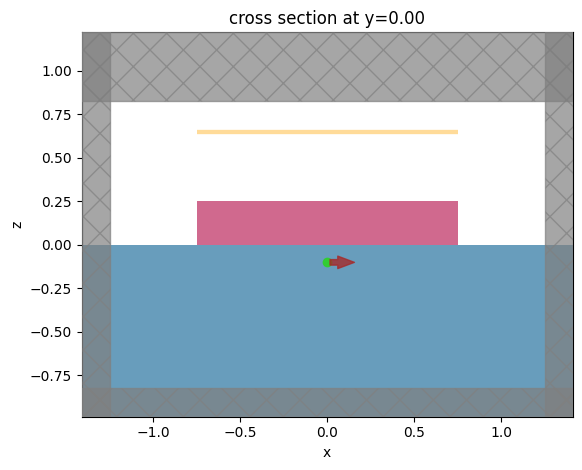

In [8]:
# number of pixels in one direction
n_pixels = int(l / pixel_size)

# initial design parameters
params0 = np.ones((n_pixels, n_pixels, 1)) * 0.5

# simulations with the initial design parameters
sims0 = make_sims(params0, beta=50.0)

# viasualize a simulation
sims0["x"].plot(y=0)
plt.show()

## Baseline Simulations

As a baseline, we will first simulate the scenario with no extractor. This result will be compared to that with the optimized extractor later on.

In [9]:
# create simulations without the extractor structure
sims_ref = {axis: sims0[axis].updated_copy(structures=[substrate]) for axis in ["x", "y", "z"]}

# run the simulations
ref_results = web.run_async(simulations=sims_ref, path_dir="data")

Output()

18:49:17 Eastern Standard Time Started working on Batch containing 3 tasks.

18:49:19 Eastern Standard Time Maximum FlexCredit cost: 0.075 for the whole     
                               batch.

                               Use 'Batch.real_cost()' to get the billed        
                               FlexCredit cost after the Batch has completed.

Output()

18:49:21 Eastern Standard Time Batch complete.

Output()

To facilitate post-processing, we will develop a function to extract the upward radiation fluxes across all simulations. When applied to the baseline simulation data, this function reveals that the flux for the dipole in the vertical direction is an order of magnitude smaller than in the horizontal directions. This occurs because most emission from a vertically oriented dipole undergoes total internal reflection at the diamond-air interface, significantly limiting the extraction efficiency.

In [10]:
def extract_fluxes(results: td.web.BatchData) -> list:
    """Postprocessing function to extract the flux data and print them."""
    fluxes = [results[axis]["field"].flux.data[0] for axis in ["x", "y", "z"]]

    for axis, flux in zip(["x", "y", "z"], fluxes):
        print(f"E{axis} dipole flux is {flux:.3f}.")

    return fluxes

flux_ref = extract_fluxes(ref_results)

Ex dipole flux is 74.819.
Ey dipole flux is 74.819.
Ez dipole flux is 4.566.


## Objective Function

Finally, before we start the optimization, we define the objective function as the minimum upward flux among the three simulations. Note that we don't apply a simply minimum since this discontinuous function will break the gradient tracking. Instead, we use a soft minimum function given by 
$$
-\tau [ln(e^{-f_x/\tau}) + ln(e^{-f_y/\tau}) + ln(e^{-f_z/\tau})],
$$

where $f_i$ denotes the upward radiation flux in the $i=[x, y, z]$ direction, and $\tau$ is the parameter that controls the "softness" of the soft minimum function. The smaller $\tau$ we use, the function is closer to the true minimum. 

In [11]:
def min_upward_flux(params: np.ndarray, beta: float) -> float:
    """Objective function for the inverse design"""
    sims = make_sims(params, beta=beta)
    batch_results = web.run_async(simulations=sims, path_dir="data", local_gradient=False, verbose=False)

    flux_data = lambda dim: np.sum(batch_results[dim]["field"].flux.data)
    exponential = lambda flux: np.exp(-flux / tau)

    flux_x = flux_data("x")
    flux_y = flux_data("y")
    flux_z = flux_data("z")
    tau = 3.5

    return -tau * np.log(exponential(flux_x) + exponential(flux_y) + exponential(flux_z))

In [12]:
# function to calculate the objective function value and its gradient with respect to the design parameters.
val_grad_fn = ag.value_and_grad(min_upward_flux)

## Optimization Loop

Now we are ready to start the optimization loop. We will use the `adam` optimizer. In each iteration, the `beta` value for the tanh projection is increased by 1 to help gradually binarize the design. In each iteration, we output the objective function value as well as plot the design region density.

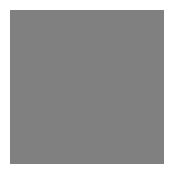

step = 1
objective = 9.460e+00


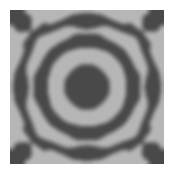

step = 2
objective = 1.473e+02


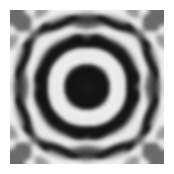

step = 3
objective = 2.429e+02


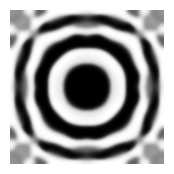

step = 4
objective = 3.533e+02


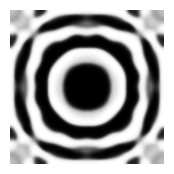

step = 5
objective = 4.827e+02


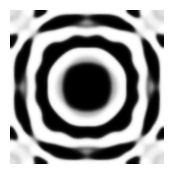

step = 6
objective = 4.553e+02


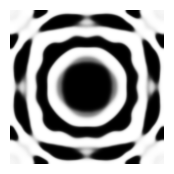

step = 7
objective = 4.055e+02


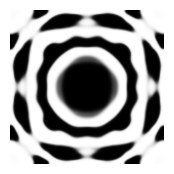

step = 8
objective = 3.311e+02


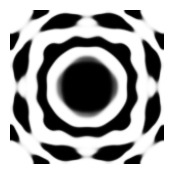

step = 9
objective = 3.423e+02


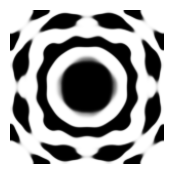

step = 10
objective = 3.745e+02


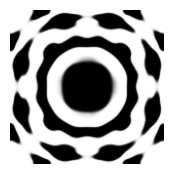

step = 11
objective = 3.926e+02


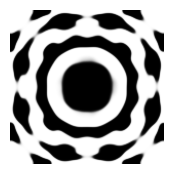

step = 12
objective = 4.214e+02


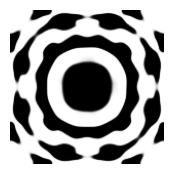

step = 13
objective = 4.211e+02


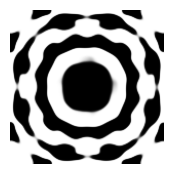

step = 14
objective = 4.538e+02


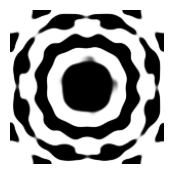

step = 15
objective = 4.526e+02


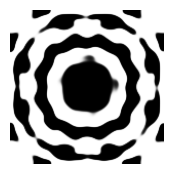

step = 16
objective = 4.416e+02


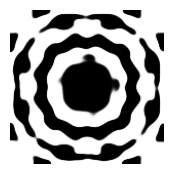

step = 17
objective = 4.448e+02


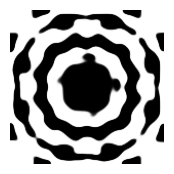

step = 18
objective = 4.526e+02


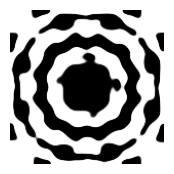

step = 19
objective = 4.791e+02


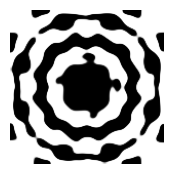

step = 20
objective = 5.037e+02


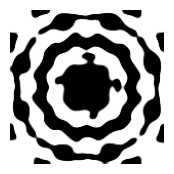

step = 21
objective = 4.942e+02


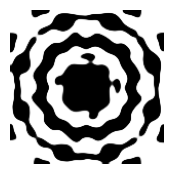

step = 22
objective = 4.952e+02


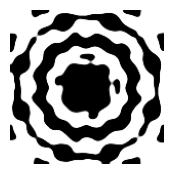

step = 23
objective = 4.787e+02


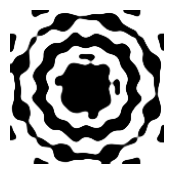

step = 24
objective = 4.709e+02


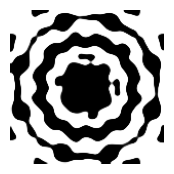

step = 25
objective = 4.882e+02


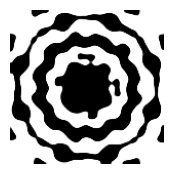

step = 26
objective = 5.120e+02


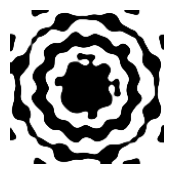

step = 27
objective = 5.338e+02


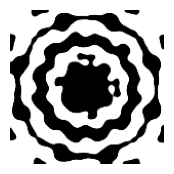

step = 28
objective = 5.582e+02


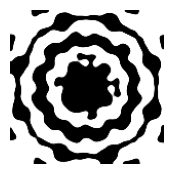

step = 29
objective = 6.051e+02


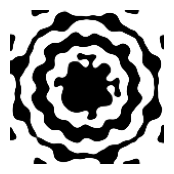

step = 30
objective = 6.312e+02


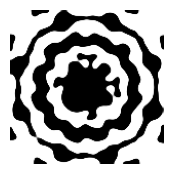

step = 31
objective = 6.362e+02


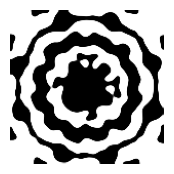

step = 32
objective = 5.960e+02


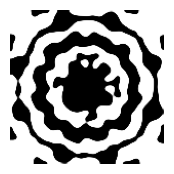

step = 33
objective = 5.935e+02


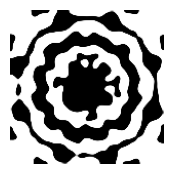

step = 34
objective = 5.666e+02


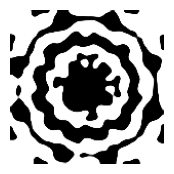

step = 35
objective = 6.031e+02


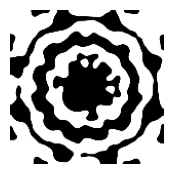

step = 36
objective = 6.183e+02


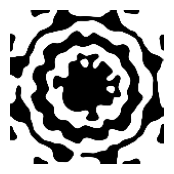

step = 37
objective = 6.204e+02


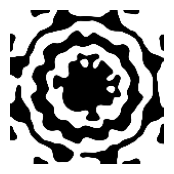

step = 38
objective = 6.018e+02


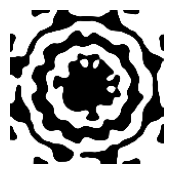

step = 39
objective = 6.043e+02


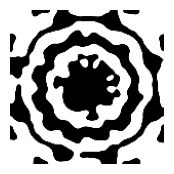

step = 40
objective = 5.897e+02


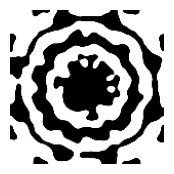

step = 41
objective = 6.134e+02


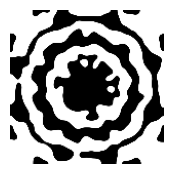

step = 42
objective = 6.411e+02


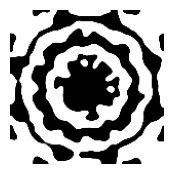

step = 43
objective = 6.415e+02


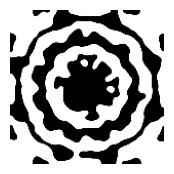

step = 44
objective = 6.484e+02


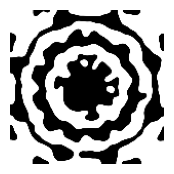

step = 45
objective = 6.562e+02


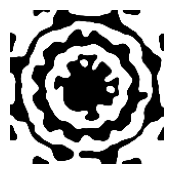

step = 46
objective = 6.687e+02


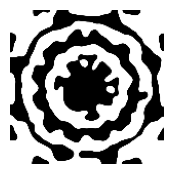

step = 47
objective = 6.820e+02


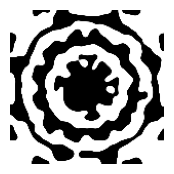

step = 48
objective = 6.834e+02


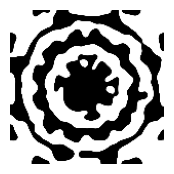

step = 49
objective = 6.737e+02


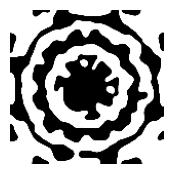

step = 50
objective = 6.862e+02


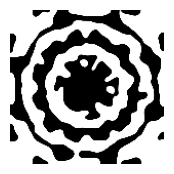

step = 51
objective = 6.899e+02


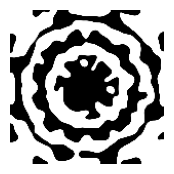

step = 52
objective = 6.843e+02


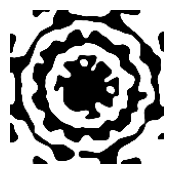

step = 53
objective = 6.877e+02


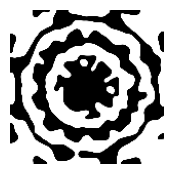

step = 54
objective = 6.988e+02


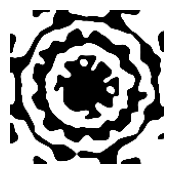

step = 55
objective = 7.031e+02


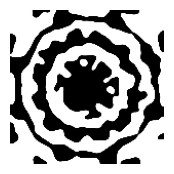

step = 56
objective = 7.098e+02


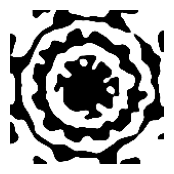

step = 57
objective = 7.115e+02


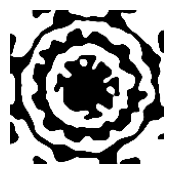

step = 58
objective = 7.128e+02


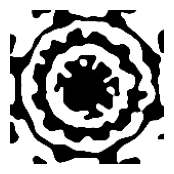

step = 59
objective = 7.123e+02


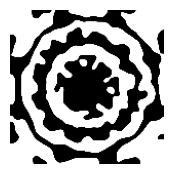

step = 60
objective = 7.145e+02


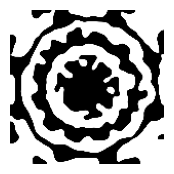

step = 61
objective = 7.064e+02


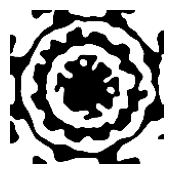

step = 62
objective = 7.019e+02


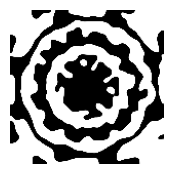

step = 63
objective = 6.817e+02


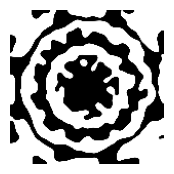

step = 64
objective = 6.386e+02


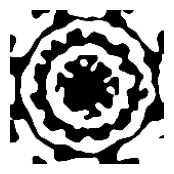

step = 65
objective = 6.757e+02


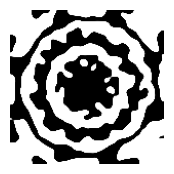

step = 66
objective = 6.525e+02


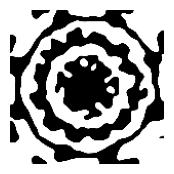

step = 67
objective = 6.413e+02


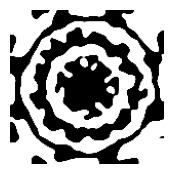

step = 68
objective = 6.927e+02


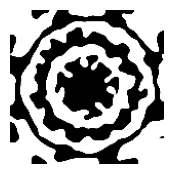

step = 69
objective = 6.424e+02


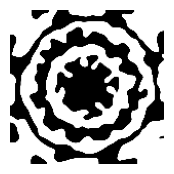

step = 70
objective = 6.354e+02


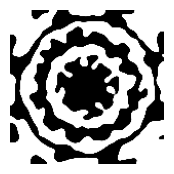

step = 71
objective = 6.622e+02


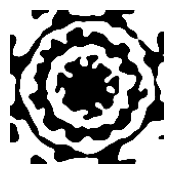

step = 72
objective = 6.896e+02


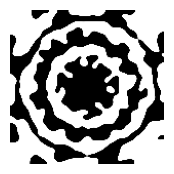

step = 73
objective = 7.041e+02


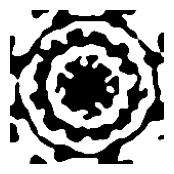

step = 74
objective = 7.079e+02


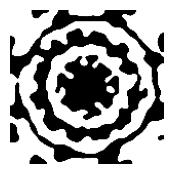

step = 75
objective = 7.138e+02


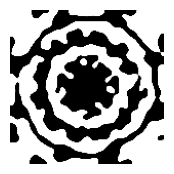

step = 76
objective = 7.263e+02


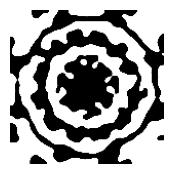

step = 77
objective = 6.616e+02


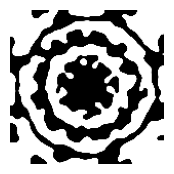

step = 78
objective = 6.939e+02


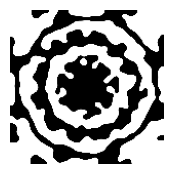

step = 79
objective = 7.050e+02


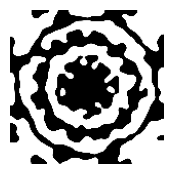

step = 80
objective = 6.277e+02


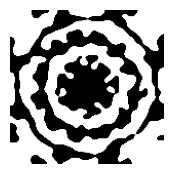

step = 81
objective = 6.235e+02


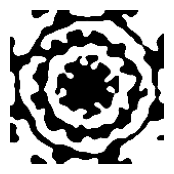

step = 82
objective = 6.575e+02


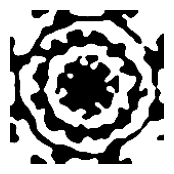

step = 83
objective = 6.683e+02


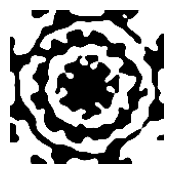

step = 84
objective = 7.273e+02


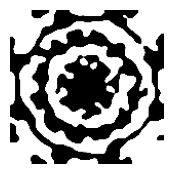

step = 85
objective = 6.553e+02


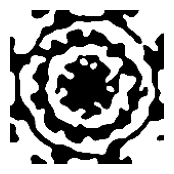

step = 86
objective = 6.617e+02


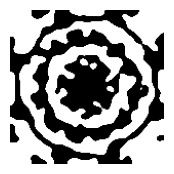

step = 87
objective = 6.601e+02


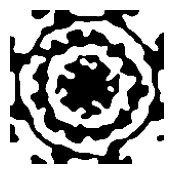

step = 88
objective = 6.545e+02


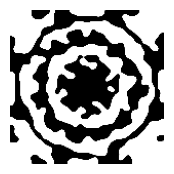

step = 89
objective = 6.578e+02


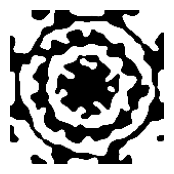

step = 90
objective = 6.866e+02


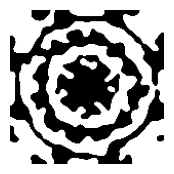

step = 91
objective = 7.179e+02


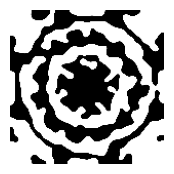

step = 92
objective = 6.978e+02


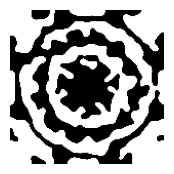

step = 93
objective = 7.039e+02


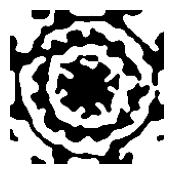

step = 94
objective = 7.156e+02


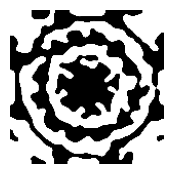

step = 95
objective = 7.153e+02


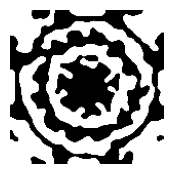

step = 96
objective = 7.409e+02


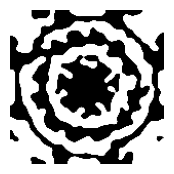

step = 97
objective = 7.377e+02


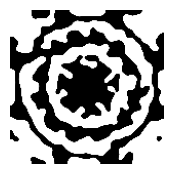

step = 98
objective = 7.366e+02


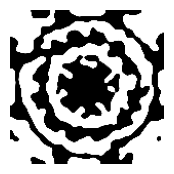

step = 99
objective = 7.466e+02


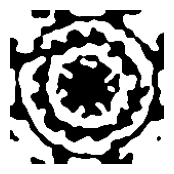

step = 100
objective = 7.468e+02


In [13]:
# hyperparameters
num_steps = 100
learning_rate = 0.2

# initialize adam optimizer with starting parameters
params = np.array(params0)
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
objective_history = []
params_history = [params]

# gradually increase the binarization strength
beta0 = 1
beta_increment = 1

beta = beta0
for i in range(num_steps):
    # compute gradient and current objective function value

    density = get_density(params, beta)
    plt.subplots(figsize=(2, 2))
    plt.imshow(np.flipud(1 - density[:, :, 0].T), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
    plt.show()

    # increase the beta value
    beta = beta0 + i * beta_increment

    # compute objective function value and gradient
    value, gradient = val_grad_fn(params, beta=beta)

    # outputs
    print(f"step = {i + 1}")
    print(f"objective = {value:.3e}")

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # cap the parameters
    params = np.clip(params, 0.0, 1.0)

    # save history
    objective_history.append(value)
    params_history.append(params)

## Optimization Result Analysis

After the optimization, we can plot the objective function as the function of iterations. A steady increase of the objective function observed. 

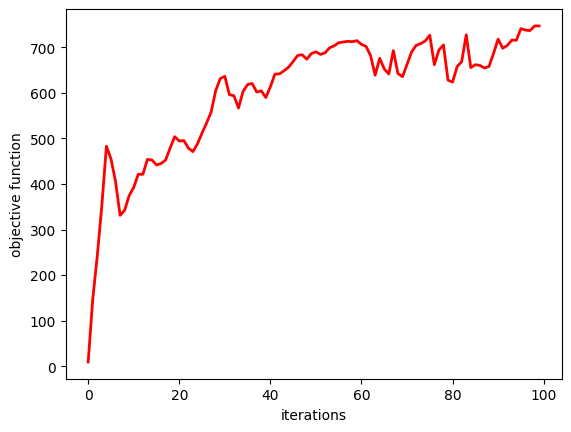

In [14]:
plt.plot(objective_history, c="red", linewidth=2)
plt.xlabel("iterations")
plt.ylabel("objective function")
plt.show()

The optimum design is not necessarily the last iteration as the objective function can fluctuate a bit. We will select the optimum design that gives the highest objective function value, re-simulate it, and calculate the flux values for different dipole orientations.

In [15]:
# optimum design iteration index
opt_index = np.argmax(objective_history)

# optimum design parameters
params_final = params_history[opt_index]

# resimulate the optimized design
sims_opt = make_sims(params_final, beta=beta)
opt_results = web.run_async(simulations=sims_opt, path_dir="data")

# extract the fluxes
flux_opt = extract_fluxes(opt_results)

Output()

20:37:09 Eastern Standard Time Started working on Batch containing 3 tasks.

20:37:17 Eastern Standard Time Maximum FlexCredit cost: 0.156 for the whole     
                               batch.

                               Use 'Batch.real_cost()' to get the billed        
                               FlexCredit cost after the Batch has completed.

Output()

20:37:28 Eastern Standard Time Batch complete.

Output()

Ex dipole flux is 763.128.
Ey dipole flux is 746.813.
Ez dipole flux is 822.827.


It's also helpful to calculate the relative flux enhancement compared to the baseline simulation without the extractor. The result indicates that the final design achieves an order-of-magnitude enhancement in upward flux for an in-plane dipole source and over two orders of magnitude for an out-of-plane dipole source, similar to what the authors of the referenced [paper](https://doi.org/10.1364/OPTICA.408611) achieved.

In [16]:
for axis, flux_o, flux_r in zip(["x", "y", "z"], flux_opt, flux_ref):
    print(f"Relative E{axis} dipole flux enhancement is {(flux_o / flux_r):.3f}.")

Relative Ex dipole flux enhancement is 10.200.
Relative Ey dipole flux enhancement is 9.982.
Relative Ez dipole flux enhancement is 180.225.


It is important to note that the optimized design is likely not fully binarized, even with the application of a tanh projection using a large `beta` value. For fabrication, however, a fully binarized design is necessary. Here, we manually enforce binarization and test if that negatively affects the design performance.

In this case, the results are only marginally affected.

In [17]:
# fully binarize the permittivity
params_binarized = np.round(params_final)

# create simulations
sims_binarized = make_sims(params_binarized, beta=beta)

# run simulations
binarized_results = web.run_async(simulations=sims_binarized, path_dir="data")

# extract results
flux_binarized = extract_fluxes(binarized_results)

Output()

20:37:35 Eastern Standard Time Started working on Batch containing 3 tasks.

20:37:38 Eastern Standard Time Maximum FlexCredit cost: 0.156 for the whole     
                               batch.

                               Use 'Batch.real_cost()' to get the billed        
                               FlexCredit cost after the Batch has completed.

Output()

20:37:52 Eastern Standard Time Batch complete.

Output()

Ex dipole flux is 755.662.
Ey dipole flux is 734.035.
Ez dipole flux is 778.540.


We would need to export a GDS file for the optimized design for fabrication. The GDS file generation will discretize the design into polygons. Depending on the algorithm, the discretization can potentially impact the design performance as well so it's good to test it. 

First we export a GDS file.

In [18]:
# gds file export
gds_path = "./misc/inv_des_diamond_light_extractor.gds"
sims_binarized["x"].to_gds_file(
    fname=gds_path,
    z=h / 2,
    permittivity_threshold=(n_GaP**2 + 1) / 2,
    frequency=freq0,
)

Then we will import the GDS file using gdstk.

In [19]:
# load the gds file we just created
lib_loaded = gdstk.read_gds(gds_path)

# create a cell dictionary with all the cells in the file
all_cells = {c.name: c for c in lib_loaded.cells}
print("Cell names: " + ", ".join(all_cells.keys()))

Cell names: MAIN


In [20]:
cell_loaded = all_cells["MAIN"]

print(cell_loaded)

Cell 'MAIN' with 28 polygons, 0 flexpaths, 0 robustpaths, 0 references, and 0 labels


We can visualize the layout.

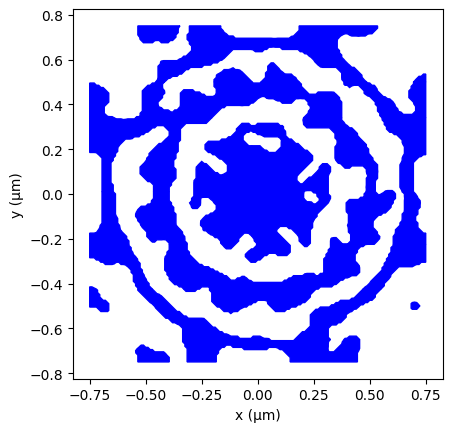

In [21]:
fig, ax = plt.subplots()

for polygon in cell_loaded.polygons:
    x, y = zip(*polygon.points)
    ax.fill(x, y, edgecolor="black", fill=True, c="blue")

ax.set_aspect("equal")
plt.xlabel("x (μm)")
plt.ylabel("y (μm)")
plt.show()

Create the extractor structure from the gds geometry. Here we don't apply any sidewall angles but if the fabrication is known to produce a certain sidewall angle, it can be tested here.

In [22]:
# create geometry from the gds layout
extractor_geo = td.Geometry.from_gds(
    cell_loaded, gds_layer=0, gds_dtype=0, axis=2, slab_bounds=(0, h)
)

# create the extractor structure
extractor = td.Structure(geometry=extractor_geo, medium=GaP)

Simulate the imported extractor and check its performance. Compared to the design before GDS export, we do see a small decrease in the performance but it's quite minimal.

In [23]:
# create simulations with the loaded gds geometry
sims_loaded = {
    axis: sims_binarized[axis].updated_copy(structures=[substrate, extractor])
    for axis in ["x", "y", "z"]
}

# run the simulations
loaded_results = web.run_async(simulations=sims_loaded, path_dir="data")

# extract results
flux_loaded = extract_fluxes(loaded_results)

for axis, flux_l, flux_r in zip(["x", "y", "z"], flux_loaded, flux_ref):
    print(f"Relative E{axis} dipole flux enhancement is {(flux_l / flux_r):.3f}.")

Output()

20:37:56 Eastern Standard Time Started working on Batch containing 3 tasks.

20:37:59 Eastern Standard Time Maximum FlexCredit cost: 0.156 for the whole     
                               batch.

                               Use 'Batch.real_cost()' to get the billed        
                               FlexCredit cost after the Batch has completed.

Output()

20:38:21 Eastern Standard Time Batch complete.

Output()

Ex dipole flux is 710.519.
Ey dipole flux is 704.014.
Ez dipole flux is 769.538.
Relative Ex dipole flux enhancement is 9.496.
Relative Ey dipole flux enhancement is 9.410.
Relative Ez dipole flux enhancement is 168.553.


Lastly we can plot the simulation in 3D to better visualize the optimized extractor geometry.

In [24]:
sims_loaded["x"].plot_3d()

## Final Remarks

In this notebook, we focus exclusively on a single frequency. In the referenced [paper](https://doi.org/10.1364/OPTICA.408611), optimization is also conducted at a single frequency, while the extractor's performance is evaluated across a broad wavelength range. This can be achieved by specifying frequency sampling points in the [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html).

The enhancement of upward radiation flux in the optimized design can arise from two mechanisms: (1) the structure redirects the dipole radiation toward the upward direction, and (2) the total radiation from the dipole is increased due to the Purcell effect. Although we do not examine the Purcell factor in this notebook, it can be analyzed as demonstrated in the tutorial provided [here](https://www.flexcompute.com/tidy3d/examples/notebooks/CavityFOM/). Based on the findings of the paper, the Purcell effect is not very significant in our case since the dipole is deeply buried (100 nm) under the surface.

In this example, we only used the filter to enforce the fabrication constraint. For better fabrication constraint compliance, one can also consider adding a fabrication penalty term in the objective function such as the one demonstrated in this [example](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd6GratingCoupler/). Before fabrication, we should also closely examine the small features in the design to ensure fabricability. 